# Exercise3

In [16]:

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.optim as optim
from torch.utils.data import DataLoader

import torchvision.datasets as datasets
import torchvision.transforms as transforms

from torch.nn.functional import conv2d, max_pool2d, cross_entropy
from tqdm import tqdm

plt.rc("figure", dpi=100)

batch_size = 100

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Device:', device)
torch.cuda.set_device(device)

# transform images into normalized tensors
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(0.5,))
])

train_dataset = datasets.MNIST(
    "./",
    download=True,
    train=True,
    transform=transform,
)

test_dataset = datasets.MNIST(
    "./",
    download=True,
    train=False,
    transform=transform,
)

train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2,
    pin_memory=True,
)

test_dataloader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2,
    pin_memory=True,
)


def init_weights(shape,device =  torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')):
    # Kaiming He initialization (a good initialization is important)
    # https://arxiv.org/abs/1502.01852
    std = np.sqrt(2. / shape[0])
    w = torch.randn(size=shape, device = device) * std 
    # to make w as a leaf node (be able to calculate gradient)
    # you have to create the tensor on device
    w.requires_grad = True
    return w


def rectify(x):
    # Rectified Linear Unit (ReLU)
    return torch.max(torch.zeros_like(x), x)

class RMSprop(optim.Optimizer):
    """
    This is a reduced version of the PyTorch internal RMSprop optimizer
    It serves here as an example
    """

    def __init__(self, params, lr=1e-3, alpha=0.5, eps=1e-8):
        defaults = dict(lr=lr, alpha=alpha, eps=eps)
        super(RMSprop, self).__init__(params, defaults)

    def step(self):
        for group in self.param_groups:
            for p in group['params']:
                grad = p.grad.data
                state = self.state[p]

                # state initialization
                if len(state) == 0:
                    state['square_avg'] = torch.zeros_like(p.data)

                square_avg = state['square_avg']
                alpha = group['alpha']

                # update running averages
                square_avg.mul_(alpha).addcmul_(grad, grad, value=1 - alpha)
                avg = square_avg.sqrt().add_(group['eps'])

                # gradient update
                p.data.addcdiv_(grad, avg, value=-group['lr'])




Device: cuda:0


  0%|          | 0/101 [00:00<?, ?it/s]

Epoch: 0
Mean Train Loss: 4.01e-01


  1%|          | 1/101 [00:07<13:04,  7.85s/it]

Mean Test Loss:  2.92e-01


 10%|▉         | 10/101 [00:51<07:27,  4.92s/it]

Epoch: 10
Mean Train Loss: 1.53e-01


 11%|█         | 11/101 [00:59<08:47,  5.86s/it]

Mean Test Loss:  2.56e-01


 20%|█▉        | 20/101 [01:44<06:37,  4.91s/it]

Epoch: 20
Mean Train Loss: 1.04e-01


 21%|██        | 21/101 [01:51<07:37,  5.72s/it]

Mean Test Loss:  4.32e-01


 30%|██▉       | 30/101 [02:36<05:55,  5.00s/it]

Epoch: 30
Mean Train Loss: 6.62e-02


 31%|███       | 31/101 [02:44<06:40,  5.72s/it]

Mean Test Loss:  5.46e-01


 40%|███▉      | 40/101 [03:29<05:05,  5.01s/it]

Epoch: 40
Mean Train Loss: 4.51e-02


 41%|████      | 41/101 [03:36<05:51,  5.86s/it]

Mean Test Loss:  6.84e-01


 50%|████▉     | 50/101 [04:22<04:19,  5.09s/it]

Epoch: 50
Mean Train Loss: 3.85e-02


 50%|█████     | 51/101 [04:29<04:52,  5.85s/it]

Mean Test Loss:  8.97e-01


 59%|█████▉    | 60/101 [05:16<03:33,  5.21s/it]

Epoch: 60
Mean Train Loss: 2.56e-02


 60%|██████    | 61/101 [05:26<04:28,  6.72s/it]

Mean Test Loss:  8.20e-01


 69%|██████▉   | 70/101 [06:11<02:38,  5.13s/it]

Epoch: 70
Mean Train Loss: 1.59e-02


 70%|███████   | 71/101 [06:20<03:02,  6.09s/it]

Mean Test Loss:  9.72e-01


 79%|███████▉  | 80/101 [07:08<01:51,  5.30s/it]

Epoch: 80
Mean Train Loss: 1.92e-02


 80%|████████  | 81/101 [07:15<01:59,  5.96s/it]

Mean Test Loss:  8.49e-01


 89%|████████▉ | 90/101 [08:01<00:56,  5.11s/it]

Epoch: 90
Mean Train Loss: 8.91e-03


 90%|█████████ | 91/101 [08:09<00:58,  5.89s/it]

Mean Test Loss:  8.86e-01


 99%|█████████▉| 100/101 [08:58<00:05,  5.85s/it]

Epoch: 100
Mean Train Loss: 5.90e-03


100%|██████████| 101/101 [09:07<00:00,  5.42s/it]

Mean Test Loss:  9.19e-01


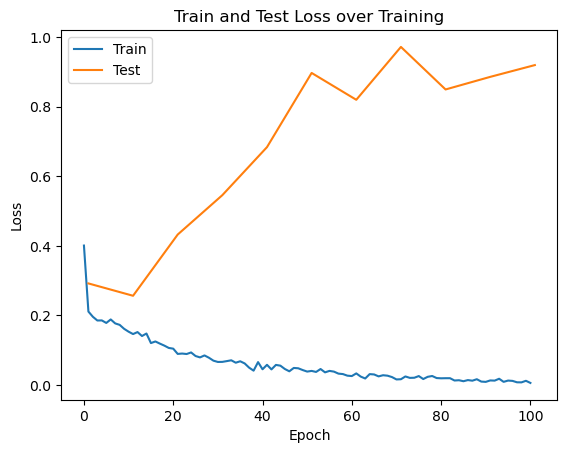

In [17]:

# define the neural network
def model(x, w_h, w_h2, w_o):
    h = rectify(x @ w_h)
    h2 = rectify(h @ w_h2)
    pre_softmax = h2 @ w_o
    return pre_softmax


# initialize weights

# input shape is (B, 784)
w_h = init_weights((784, 625))
# hidden layer with 625 neurons
w_h2 = init_weights((625, 625))
# hidden layer with 625 neurons
w_o = init_weights((625, 10))
# output shape is (B, 10)

optimizer = RMSprop(params=[w_h, w_h2, w_o])


n_epochs = 100

train_loss = []
test_loss = []

# put this into a training loop over 100 epochs
for epoch in tqdm(range(n_epochs + 1)):
    train_loss_this_epoch = []
    for idx, batch in enumerate(train_dataloader):
        x, y = batch

        # our model requires flattened input
        x = x.reshape(batch_size, 784).to(device)
        # feed input through model
        noise_py_x = model(x, w_h, w_h2, w_o)

        # reset the gradient
        optimizer.zero_grad()

        # the cross-entropy loss function already contains the softmax
        loss = cross_entropy(noise_py_x, y.to(device), reduction="mean")

        train_loss_this_epoch.append(float(loss.to(device)))

        # compute the gradient
        loss.backward()
        # update weights
        optimizer.step()

    train_loss.append(np.mean(train_loss_this_epoch))

    # test periodically
    if epoch % 10 == 0:
        print(f"Epoch: {epoch}")
        print(f"Mean Train Loss: {train_loss[-1]:.2e}")
        test_loss_this_epoch = []

        # no need to compute gradients for validation
        with torch.no_grad():
            for idx, batch in enumerate(test_dataloader):
                x, y = batch
                x = x.reshape(batch_size, 784).to(device)
                noise_py_x = model(x, w_h, w_h2, w_o)

                loss = cross_entropy(noise_py_x, y.to(device), reduction="mean")
                test_loss_this_epoch.append(float(loss.to(device)))

        test_loss.append(np.mean(test_loss_this_epoch))

        print(f"Mean Test Loss:  {test_loss[-1]:.2e}")

plt.plot(np.arange(n_epochs + 1), train_loss, label="Train")
plt.plot(np.arange(1, n_epochs + 2, 10), test_loss, label="Test")
plt.title("Train and Test Loss over Training")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

## 4.1 Create a Convolutional network

In [21]:
def dropout(X, p_drop=0.5):
    if p_drop >= 1 or p_drop <= 0:
        return X  

    mask = torch.bernoulli(torch.full_like(X, 1 - p_drop))
    X_drop = X * mask / (1 - p_drop)

    return X_drop


def convolutional_layer(previous_layer, weightvector, p_drop_input):
    convolutional_layer_0 = rectify(conv2d(previous_layer, weightvector))
    # reduces (2 ,2) window to 1 pixel
    subsampling_layer = max_pool2d(convolutional_layer_0, (2, 2))
    out_layer = dropout(subsampling_layer, p_drop_input)
    # out_layer = torch.nn.functional.dropout(subsampling_layer, p=p_drop_input, inplace=False)
    return out_layer


# define the neural network
def LeNet_model(x, w_h1_1,w_h1_2,w_h1_3, w_h2, w_o, p_drop_input=0.5, p_drop_hidden=0.5):
    h1_1 = convolutional_layer(x, w_h1_1, p_drop_input)
    h1_2 = convolutional_layer(h1_1, w_h1_2, p_drop_hidden)
    h1_3 = convolutional_layer(h1_2, w_h1_3, p_drop_hidden)

    h1_3 = torch.reshape(h1_3, (-1, 128)) # number_of_output_pixel is determined by previous layers
    h2 = rectify(h1_3 @ w_h2)
    pre_softmax = h2 @ w_o
    return pre_softmax

In [22]:

# initialize weights

# input shape is (B, 784)
w_h1_1 = init_weights((32, 1, 5, 5)).to(device)
w_h1_2 = init_weights((64, 32, 5, 5)).to(device)
w_h1_3 = init_weights((128, 64, 2, 2)).to(device)
# hidden layer with 625 neurons
w_h2 = init_weights((128, 625)).to(device)
# hidden layer with 625 neurons
w_o = init_weights((625, 10)).to(device)
# output shape is (B, 10)

optimizer = RMSprop(params=[w_h1_1, w_h1_2, w_h1_3, w_h2, w_o])

n_epochs = 100

train_loss = []
test_loss = []

# put this into a training loop over 100 epochs
for epoch in tqdm(range(n_epochs + 1)):
    train_loss_this_epoch = []
    for idx, batch in enumerate(train_dataloader):
        trainX, trainY = batch

        # our model requires flattened input
        # x = x.reshape(batch_size, 784)
        trainX = trainX.reshape(-1, 1, 28, 28).to(device)  # training data

        # feed input through model
        noise_py_x = LeNet_model(
            trainX, w_h1_1, w_h1_2, w_h1_3, w_h2, w_o)

        # reset the gradient
        optimizer.zero_grad()

        trainY = trainY.to(device)
        # the cross-entropy loss function already contains the softmax
        loss = cross_entropy(noise_py_x, trainY, reduction="mean")

        train_loss_this_epoch.append(float(loss.to('cpu')))

        # compute the gradient
        loss.backward()
        # update weights
        optimizer.step()

    train_loss.append(np.mean(train_loss_this_epoch))

    # test periodically
    if epoch % 10 == 0:
        print(f"Epoch: {epoch}")
        print(f"Mean Train Loss: {train_loss[-1]:.2e}")
        test_loss_this_epoch = []

        # no need to compute gradients for validation
        with torch.no_grad():
            for idx, batch in enumerate(test_dataloader):
                testX, testY = batch
                testX = testX.reshape(-1, 1, 28, 28).to(device)  # test data
                noise_py_x = LeNet_model(
                    testX, w_h1_1, w_h1_2, w_h1_3, w_h2, w_o).to(device)

                testY = testY.to(device)
                loss = cross_entropy(noise_py_x, testY, reduction="mean")
                test_loss_this_epoch.append(float(loss.to("cpu")))

        test_loss.append(np.mean(test_loss_this_epoch))

        print(f"Mean Test Loss:  {test_loss[-1]:.2e}")

plt.plot(np.arange(n_epochs + 1), train_loss, label="Train")
plt.plot(np.arange(1, n_epochs + 2, 10), test_loss, label="Test")
plt.title("Train and Test Loss over Training")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

  0%|          | 0/101 [00:00<?, ?it/s]

Epoch: 0
Mean Train Loss: 3.70e+00


  1%|          | 1/101 [00:09<15:12,  9.13s/it]

Mean Test Loss:  1.19e+00


 10%|▉         | 10/101 [01:04<09:26,  6.23s/it]

Epoch: 10
Mean Train Loss: 3.78e-01


 11%|█         | 11/101 [01:14<11:04,  7.38s/it]

Mean Test Loss:  3.49e-01


 18%|█▊        | 18/101 [01:59<08:49,  6.39s/it]